In [1]:
import Model as md
import timm
import data as dta
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import DataLoader
from absl import app
from absl import flags
from absl import logging
import os
from tqdm import tqdm

from torch.cuda import amp
import pandas as pd
import math

In [2]:
encoder = timm.create_model('tf_efficientnetv2_m', pretrained=False, num_classes=0).cuda()
proj_head = md.Projection_Head(1280, 1).cuda()
sup_head = md.Supervised_Head(proj_head.output, 5).cuda()

In [3]:
transf_eval = T.Compose([
    T.CenterCrop(400),
    T.Resize(112),
    T.ToTensor(),
])

In [4]:
astro_ds = dta.AstroDataset('nairTest.csv', 'imagenes_clasificadas_nair/', transform=transf_eval)
dataset_astro = DataLoader(astro_ds,batch_size=128, shuffle=False,num_workers=6)

In [5]:
checkpoint = torch.load('finetuned_model_head1/model.pt')
encoder.load_state_dict(checkpoint['encoder'])
proj_head.load_state_dict(checkpoint['projection_head'], strict=False)
sup_head.load_state_dict(checkpoint['supervised_head'])

<All keys matched successfully>

In [6]:
encoder.eval()
proj_head.eval()
sup_head.eval()

Supervised_Head(
  (supervised_head): Linear(in_features=1280, out_features=5, bias=True)
)

In [7]:
softmax = nn.Softmax(dim=1)

In [8]:
tqdm_loop = tqdm(enumerate(dataset_astro), total=len(dataset_astro), leave=True)
acc = 0
normalized_logits, prediction_list= [], []
for batch_idx, data in tqdm_loop:
    with torch.no_grad():
        image = data[0].cuda()
        labels = data[1].cuda()
        output_val = sup_head(proj_head(encoder(image)))
        output_val = softmax(output_val)
        normalized_logits.append(output_val.detach().cpu().numpy())
        acc_val = torch.argmax(output_val,dim=1)
        prediction_list.append(acc_val.detach().cpu().numpy())
        acc_val = (acc_val == labels).float().sum()
        acc += acc_val
acc /= astro_ds.__len__()
print('Acc {}'.format(acc*100))

100%|██████████| 32/32 [00:07<00:00,  4.52it/s]

Acc 67.68004608154297


# Lets code confusion matrix and other metrics C:

In [9]:
!pip install -U scikit-learn
!pip install matplotlib
!pip install seaborn

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.8/site-packages (0.24.2)


In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from itertools import cycle
import os

In [11]:
#plt Config
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [12]:
dataset = pd.read_csv('nairTest.csv')
true_labels = dataset['new_class'].values
predicted = np.concatenate(np.array(prediction_list, dtype=object), axis=0)
n_logits = np.concatenate(np.array(normalized_logits, dtype=object), axis=0)

# Confusion matrix

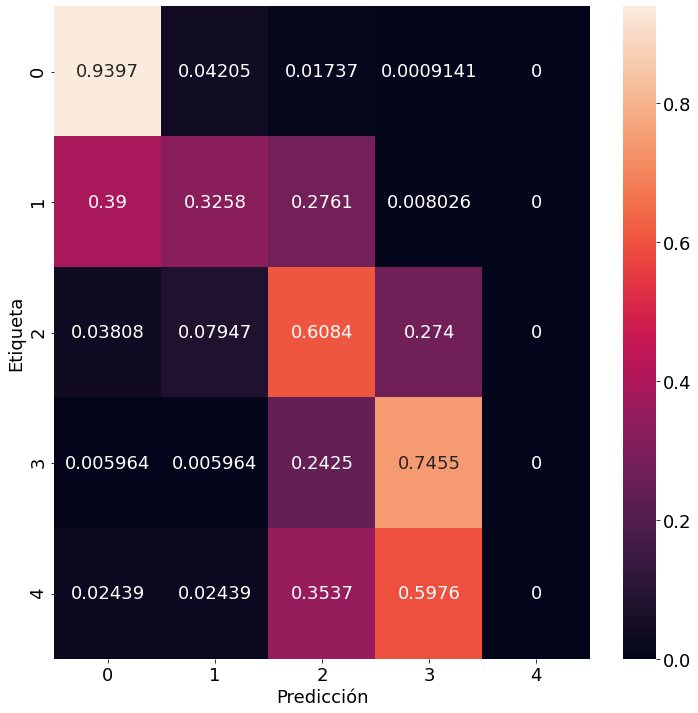

In [13]:
confusion = confusion_matrix(true_labels , predicted)
n_confusion = [confusion[i,:]/confusion.sum(axis=1)[i] for i in range(5)]
plt.figure(figsize=(12,12))
sns.heatmap(n_confusion, annot=True, fmt='.4g')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta')
#plt.savefig("confusion_head3.pdf", format = 'pdf', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

# ROC - AUC

In [14]:
one_hot = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])

FPR, TPR, ACC = [], [], []
for i in range(5):
    fpr, tpr, _ = roc_curve(one_hot[:,i], n_logits[:,i])
    acc = auc(fpr, tpr)
    FPR.append(fpr)
    TPR.append(tpr)
    ACC.append(acc)

#compute macro avg ROC
all_FPR = np.unique(np.concatenate([FPR[i] for i in range(5)]))
mean_TPR = np.zeros_like(all_FPR)
for i in range(5):
    mean_TPR += np.interp(all_FPR, FPR[i], TPR[i])
mean_TPR /= 5
macro_AUC = auc(all_FPR, mean_TPR)

# Compute micro-average ROC
micro_FPR, micro_TPR, _ = roc_curve(one_hot.ravel(), n_logits.ravel())
micro_ACC = auc(micro_FPR, micro_TPR)

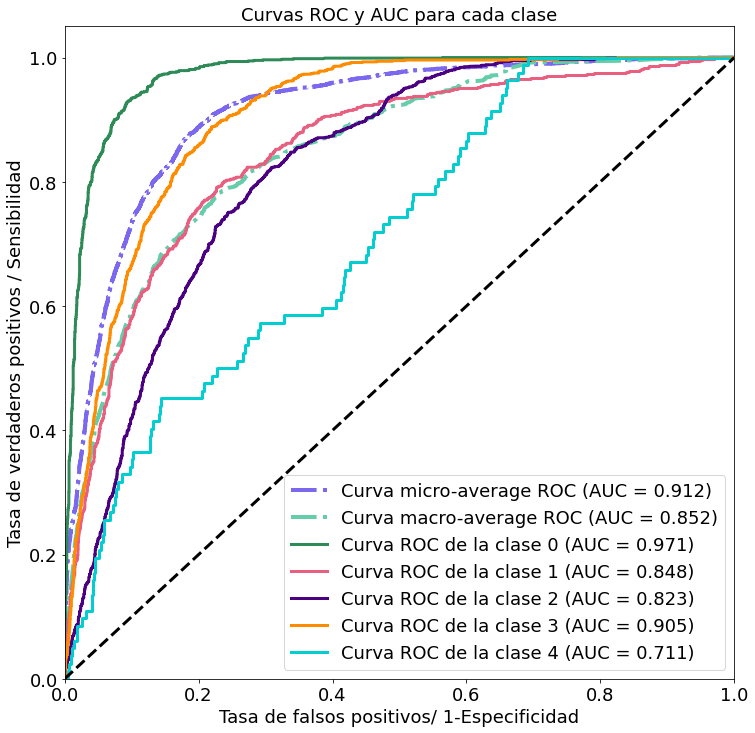

In [15]:
plt.figure(figsize=(12,12))
ax =plt.plot(micro_FPR, micro_TPR,
         label='Curva micro-average ROC (AUC = {0:0.3f})'
               ''.format(micro_ACC),
         color='mediumslateblue', linestyle='-.', linewidth=4)

plt.plot(all_FPR, mean_TPR,
         label='Curva macro-average ROC (AUC = {0:0.3f})'
               ''.format(macro_AUC),
         color='mediumaquamarine', linestyle='-.', linewidth=4)

colors = cycle(['seagreen','#e85f7f','indigo','darkorange','darkturquoise'])
for i, color in zip(range(5), colors):
    plt.plot(FPR[i], TPR[i], color=color, lw=3,
             label='Curva ROC de la clase {0} (AUC = {1:0.3f})'
             ''.format(i, ACC[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Curvas ROC y AUC para cada clase')
plt.xlabel('Tasa de falsos positivos/ 1-Especificidad')#, fontsize=16)
plt.ylabel('Tasa de verdaderos positivos / Sensibilidad')
plt.legend(loc="lower right")
#plt.savefig("roc_head3.pdf", format = 'pdf', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

# Curvas Precision - Recall

In [16]:
PRECISION, RECALL, avg_PRECISION = [], [], []
for i in range(5):
    precision, recall, _ = precision_recall_curve(one_hot[:, i],n_logits[:, i])
    average_precision = average_precision_score(one_hot[:, i],n_logits[:, i])
    PRECISION.append(precision)
    RECALL.append(recall)
    avg_PRECISION.append(average_precision)

#micro precision recall
micro_precision, micro_recall,_ = precision_recall_curve(one_hot.ravel(), n_logits.ravel())
micro_avg_precision = average_precision_score(one_hot, n_logits, average="micro")

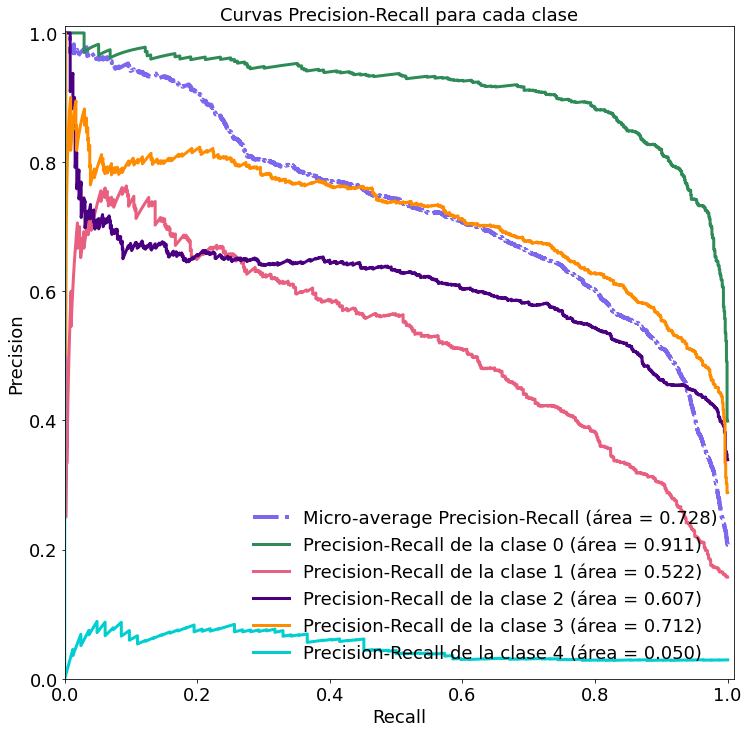

In [17]:
plt.figure(figsize=(12,12))
ax =plt.plot(micro_recall, micro_precision,
         label='Micro-average Precision-Recall (área = {0:0.3f})'
               ''.format(micro_avg_precision),
         color='mediumslateblue', linestyle='-.', linewidth=4)

colors = cycle(['seagreen','#e85f7f','indigo','darkorange','darkturquoise'])
for i, color in zip(range(5), colors):
    plt.plot(RECALL[i], PRECISION[i], color=color, lw=3,
             label='Precision-Recall de la clase {0} (área = {1:0.3f})'
             ''.format(i, avg_PRECISION[i]))

plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.title('Curvas Precision-Recall para cada clase')
plt.xlabel('Recall')#, fontsize=16)
plt.ylabel('Precision')
plt.legend(loc="lower right", framealpha=0.0)
#plt.savefig("precision-recall_head3.pdf", format = 'pdf', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

# Otras metricas

In [18]:
print(classification_report(true_labels, predicted, target_names=['Clase 0', 'Clase 1', 'Clase 2',
                                                                 'Clase 3', 'Clase 4'], digits=4))

              precision    recall  f1-score   support

     Clase 0     0.7758    0.9397    0.8499      1094
     Clase 1     0.5751    0.3258    0.4160       623
     Clase 2     0.6130    0.6084    0.6107      1208
     Clase 3     0.6602    0.7455    0.7003      1006
     Clase 4     0.0000    0.0000    0.0000        82

    accuracy                         0.6768      4013
   macro avg     0.5248    0.5239    0.5154      4013
weighted avg     0.6508    0.6768    0.6557      4013



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
